<h1>Exploring Toronto</h1>

A pizza owner has two Pizza Restaurants located in Manhattan, to be exactly in Carnegie Hill and Hamilton Heights, and he wants to open a new location in Toronto. He wants to know what possible locations are good to open his new restaurant. Currently the two locations where he has his restaurants are very good, so he wants to know more information about the current neighborhoods in order to know if there are some neighborhoods similiar in Toronto.

We will start analyzing the neighborhoods in Manhattan. We will explore more about these two neighborhoods were the pizza restaurants are operating and try to tell more about these neighborhoods in order to get more information and after this, we will look for similar neighborhoods in Toronto.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

Download New York Neighborhood and Borough Data and extract useful information

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']
print('Data downloaded!')

Data downloaded!


Format data and store it into DataFrame.

In [3]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Examinate first 5 elements of DataFrame

In [4]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Extract information of Manhattan

In [5]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


Lets print all the neighborhoods in Manhatan and show the two neighborhoods where the pizza places are located

In [6]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
colorM = ""
# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    if label=='Carnegie Hill' or label=="Hamilton Heights":
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#B90000',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan)  
    else:
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_manhattan) 
    
map_manhattan

In [7]:
ng = ['Carnegie Hill', 'Hamilton Heights']
neighborhoods_df= neighborhoods[neighborhoods.Neighborhood.isin(ng)].reset_index(drop=True)
neighborhoods_df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Hamilton Heights,40.823604,-73.949688
1,Manhattan,Carnegie Hill,40.782683,-73.953256


Now we will explore with more detail these two neighborhoods so we can be able to give more details about them using Foursquare and this will help us to find similarities in Neighborhoods of Toronto

In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
NY_neighborhood_venues = getNearbyVenues(names=neighborhoods_df['Neighborhood'],
                                   latitudes=neighborhoods_df['Latitude'],
                                   longitudes=neighborhoods_df['Longitude']
                                  )


Hamilton Heights
Carnegie Hill


Lets observe the quantity of top100 venues for each neighborhood

In [11]:
ng_venues_group = NY_neighborhood_venues[['Neighborhood', 'Venue','Venue Category']].groupby(['Neighborhood', 'Venue Category']).count().sort_values(['Venue'], ascending=False)
NY_neighborhood_venues.groupby('Neighborhood').count()
# ng_venues_group

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Carnegie Hill,100,100,100,100,100,100
Hamilton Heights,60,60,60,60,60,60


In [13]:
# one hot encoding
df_onehot = pd.get_dummies(NY_neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighborhood'] = NY_neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

# toronto_onehot.head()
df_grouped = df_onehot.groupby('Neighborhood').sum().reset_index()
print("df_venues_grouped shape: ", df_grouped.shape)


df_venues_grouped shape:  (2, 78)


Lets get the top 10 most common venues in each neighborhood and put them in a Data frame

In [14]:
num_top_venues = 10
df_top1 = pd.DataFrame(columns = ['venue', 'freq'])
i = 1
for hood in df_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    if i == 1:
        df_top1 = temp.copy()
        df_top1.rename(columns={'freq':hood}, inplace=True)
    else:
        df_top1 = df_top1.join(temp[['freq']])
        df_top1.rename(columns={'freq':hood}, inplace=True)
        
    i = i + 1
    

----Carnegie Hill----
                 venue  freq
0          Pizza Place   6.0
1          Coffee Shop   5.0
2                 Café   4.0
3       Cosmetics Shop   4.0
4          Yoga Studio   3.0
5        Grocery Store   3.0
6                  Gym   3.0
7  Japanese Restaurant   3.0
8    French Restaurant   3.0
9            Bookstore   3.0


----Hamilton Heights----
                venue  freq
0  Mexican Restaurant   5.0
1         Pizza Place   4.0
2         Coffee Shop   4.0
3                Café   4.0
4   Indian Restaurant   2.0
5  Chinese Restaurant   2.0
6    Sushi Restaurant   2.0
7              School   2.0
8      Sandwich Place   2.0
9        Liquor Store   2.0




In [15]:
df_top1.head()

,venue,Carnegie Hill,Hamilton Heights
1,American Restaurant,1.0,0.0
2,Argentinian Restaurant,1.0,0.0
3,Art Museum,1.0,0.0
4,Bagel Shop,1.0,0.0
5,Bakery,2.0,2.0


Lets plot a histogram with the distribution of each 

Text(0.5,1,'Carnegie Hill venues')

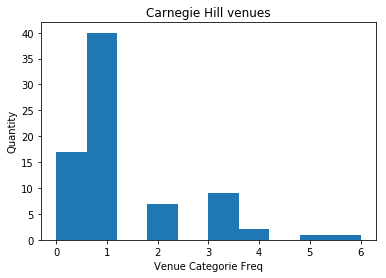

In [16]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(df_top1["Carnegie Hill"])

# set x/y labels and plot title
plt.pyplot.xlabel("Venue Categorie Freq")
plt.pyplot.ylabel("Quantity")
plt.pyplot.title("Carnegie Hill venues")

Text(0.5,1,'Hamilton Heights venues')

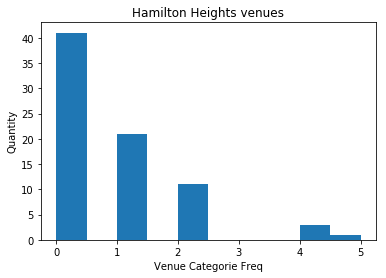

In [17]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(df_top1["Hamilton Heights"])

# set x/y labels and plot title
plt.pyplot.xlabel("Venue Categorie Freq")
plt.pyplot.ylabel("Quantity")
plt.pyplot.title("Hamilton Heights venues")

In [18]:
# The code was removed by Watson Studio for sharing.

In [19]:
df_Toronto = df_Toronto[df_Toronto['Borough'].str.contains("Toronto")]
df_Toronto = df_Toronto.drop("Postcode", axis=1)

In [20]:
df_Toronto = df_Toronto.append(neighborhoods_df)
df_Toronto.tail()

,Borough,Neighborhood,Latitude,Longitude
97,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
99,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558
0,Manhattan,Hamilton Heights,40.823604,-73.949688
1,Manhattan,Carnegie Hill,40.782683,-73.953256


This information will help us to find similarities in New York and Toronto neighborhoods using Foursquare API

In [21]:
Total_neighborhood_venues = getNearbyVenues(names=df_Toronto['Neighborhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude']
                                  )

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

Lets see what are the most commmon venues, ordered from most common to less common

In [35]:
ng_venues_group_T = Total_neighborhood_venues[['Neighborhood', 'Venue','Venue Category']].groupby(['Neighborhood', 'Venue Category']).count().sort_values(['Venue'], ascending=False)
ng_venues_group_T

Venue
Neighborhood                                       Venue Category                        
Central Bay Street                                 Coffee Shop                         13
Design Exchange, Toronto Dominion Centre           Coffee Shop                         12
Harbourfront East, Toronto Islands, Union Station  Coffee Shop                         12
Commerce Court, Victoria Hotel                     Coffee Shop                         11
Stn A PO Boxes 25 The Esplanade                    Coffee Shop                         10
First Canadian Place, Underground city             Coffee Shop                          9
                                                   Café                                 9
The Danforth West, Riverdale                       Greek Restaurant                     8
Chinatown, Grange Park, Kensington Market          Café                                 8
Little Portugal, Trinity                           Bar                                  8
Design Exchange, Toronto Dominion Centre           Hotel                                8
Ryerson, Garden District                           Coffee Shop                          8
Design Exchange, Toronto Dominion Centre           Café                                 8
St. James Town                                     Coffee Shop                          8
Commerce Court, Victoria Hotel                     Café                                 7
Harbourfront, Regent Park                          Coffee Shop                          7
Ryerson, Garden District                           Clothing Store                       7
Commerce Court, Victoria Hotel                     Hotel                                6
Adelaide, King, Richmond                           Coffee Shop                          6
Church and Wellesley                               Japanese Restaurant                  6
                                                   Coffee Shop                          6
Chinatown, Grange Park, Kensington Market          Vegetarian / Vegan Restaurant        6
Carnegie Hill                                      Pizza Place                          6
Church and Wellesley                               Gay Bar                              5
Hamilton Heights                                   Mexican Restaurant                   5
Berczy Park                                        Coffee Shop                          5
Harbourfront East, Toronto Islands, Union Station  Aquarium                             5
Carnegie Hill                                      Coffee Shop                          5
Harbord, University of Toronto                     Café                                 5
Adelaide, King, Richmond                           Café                                 5
Harbourfront East, Toronto Islands, Union Station  Hotel                                5
St. James Town                                     Hotel                                5
Chinatown, Grange Park, Kensington Market          Bar                                  5
St. James Town                                     Restaurant                           5
                                                   Café                                 5
Commerce Court, Victoria Hotel                     Restaurant                           5
Central Bay Street                                 Café                                 5
Design Exchange, Toronto Dominion Centre           Restaurant                           5
Adelaide, King, Richmond                           Steakhouse                           4
                                                   Thai Restaurant                      4
Ryerson, Garden District                           Cosmetics Shop                       4
Studio District                                    Café                                 4
Runnymede, Swansea                                 Café                                 4
First Canadian Place, Underground 

In [22]:
total_onehot = pd.get_dummies(Total_neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
total_onehot['Neighborhood'] = Total_neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [total_onehot.columns[-1]] + list(total_onehot.columns[:-1])
total_onehot = total_onehot[fixed_columns]

total_grouped = total_onehot.groupby('Neighborhood').sum().reset_index()

total_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0,0,0,0,0,0,0,0,0,4,0,0,0,1,1,0,2,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,1,0,1,2,0,0,3,1,0,0,5,0,0,0,0,0,0,0,0,2,0,6,0,0,0,1,0,0,0,2,0,0,2,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,1,0,3,1,0,0,0,0,0,0,0,0,0,0,3,0,1,1,0,0,0,1,2,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,2,0,0,1,1,0,0,0,0,0,1,0,0,2,0,2,1,0,0,0,0,1,0,1,0,0,

And the list of top10 venues per neighborhood

In [23]:
num_top_venues = 10

for hood in total_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = total_grouped[total_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop   6.0
1                 Café   5.0
2           Steakhouse   4.0
3  American Restaurant   4.0
4      Thai Restaurant   4.0
5               Bakery   3.0
6                  Bar   3.0
7                Hotel   3.0
8                  Gym   3.0
9         Burger Joint   3.0


----Berczy Park----
                venue  freq
0         Coffee Shop   5.0
1        Cocktail Bar   3.0
2          Steakhouse   2.0
3            Beer Bar   2.0
4                Café   2.0
5         Cheese Shop   2.0
6              Bakery   2.0
7  Seafood Restaurant   2.0
8      Farmers Market   2.0
9          Restaurant   2.0


----Brockton, Exhibition Place, Parkdale Village----
                    venue  freq
0          Breakfast Spot   2.0
1             Coffee Shop   2.0
2                    Café   2.0
3                     Bar   1.0
4  Furniture / Home Store   1.0
5            Climbing Gym   1.0
6    Caribbean Restaurant   1.0
7      

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's put this information in a data frame

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = total_grouped['Neighborhood']

for ind in np.arange(total_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(total_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)


(40, 11)


In [26]:
neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Hotel,Burger Joint,Bar,Gym,Bakery
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Café,Cheese Shop,Restaurant,Bakery,Farmers Market,Seafood Restaurant,Beer Bar
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Burrito Place,Restaurant,Bar,Stadium,Furniture / Home Store,Italian Restaurant,Climbing Gym
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Plane,Boat or Ferry,Sculpture Garden,Boutique,Airport Gate,Airport,Harbor / Marina
5,"Cabbagetown, St. James Town",Coffee Shop,Bakery,Italian Restaurant,Café,Restaurant,Market,Pub,Pizza Place,Pet Store,Pharmacy
6,Carnegie Hill,Pizza Place,Coffee Shop,Cosmetics Shop,Café,Yoga Studio,Bookstore,Japanese Restaurant,Spa,Gym,Grocery Store
7,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Burger Joint,Japanese Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Spa,Bar,Sandwich Place
8,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Bar,Coffee Shop,Bakery,Mexican Restaurant,Dumpling Restaurant,Chinese Restaurant,Vietnamese Restaurant,Burger Joint
9,Christie,Grocery Store,Café,Park,Restaurant,Coffee Shop,Athletics & Sports,Italian Restaurant,Nightclub,Baby Store,Diner


Now let's apply k-means cluster algorithm using k=4 for clustering all the common neighborhoods based on the most common venues

In [27]:
# set number of clusters
kclusters = 4

total_grouped_clustering = total_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(total_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 2, 0, 0, 0, 2, 3, 1, 3, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0, 3], dtype=int32)

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

total_merged = df_Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
total_merged = total_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

total_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,2,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Mexican Restaurant,Theater,Historic Site,Farmers Market
9,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,3,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,Tea Room,Sporting Goods Shop,Fast Food Restaurant,Restaurant
15,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Hotel,Restaurant,Café,Cosmetics Shop,Gastropub,Italian Restaurant,Breakfast Spot,Bakery,Gym
19,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Music Venue,Pub,Falafel Restaurant,Exhibit,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
20,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Cocktail Bar,Steakhouse,Café,Cheese Shop,Restaurant,Bakery,Farmers Market,Seafood Restaurant,Beer Bar
24,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Café,Italian Restaurant,Burger Joint,Japanese Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Spa,Bar,Sandwich Place
25,Downtown Toronto,Christie,43.669542,-79.422564,0,Grocery Store,Café,Park,Restaurant,Coffee Shop,Athletics & Sports,Italian Restaurant,Nightclub,Baby Store,Diner
30,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,1,Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Hotel,Burger Joint,Bar,Gym,Bakery
31,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259,0,Supermarket,Pharmacy,Bakery,Gym,Gym / Fitness Center,Pool,Music Venue,Discount Store,Middle Eastern Restaurant,Café
36,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,1,Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Restaurant,Pizza Place,Bakery,Fried Chicken Joint,Brewery


Let's plot the distribution of the clustered neighborhoods in a pie chart

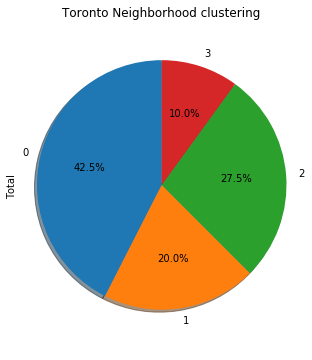

In [29]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
total_cl = total_merged[['Cluster Labels', 'Borough']].groupby('Cluster Labels').count().reset_index()
total_cl.rename(columns={'Borough':'Total'}, inplace=True)
# total_cl
total_cl['Total'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                            )

plt.title('Toronto Neighborhood clustering')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

And finally let's take a look of the recommendation for the pizza owner of possible neighborhoods to open the new restaurant in Toronto

In [30]:
total_merged.loc[total_merged['Cluster Labels'] == 3, total_merged.columns[[1] + list(range(5, total_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Ryerson, Garden District",Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,Tea Room,Sporting Goods Shop,Fast Food Restaurant,Restaurant
84,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Bar,Coffee Shop,Bakery,Mexican Restaurant,Dumpling Restaurant,Chinese Restaurant,Vietnamese Restaurant,Burger Joint
0,Hamilton Heights,Mexican Restaurant,Coffee Shop,Pizza Place,Café,Cocktail Bar,Indian Restaurant,Liquor Store,Deli / Bodega,Yoga Studio,Chinese Restaurant
1,Carnegie Hill,Pizza Place,Coffee Shop,Cosmetics Shop,Café,Yoga Studio,Bookstore,Japanese Restaurant,Spa,Gym,Grocery Store
